In [1]:
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, plot_roc_curve, 
                             accuracy_score, recall_score, precision_score, f1_score)

In [2]:
pd.set_option('display.max_colwidth', None)
# download a dataset with a description of each column
feat_def = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')

accepted_df = pd.read_csv('data/accepted_16_to_18.csv')
print(accepted_df.info())
accepted_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482754 entries, 0 to 482753
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   term              482754 non-null  object 
 1   int_rate          482754 non-null  float64
 2   grade             482754 non-null  object 
 3   dti               482754 non-null  float64
 4   loan_status       482754 non-null  int64  
 5   emp_length        482754 non-null  object 
 6   loan_amnt         482754 non-null  float64
 7   annual_inc        482754 non-null  float64
 8   application_type  482754 non-null  object 
 9   home_ownership    482754 non-null  object 
 10  date              482754 non-null  object 
 11  zip_code          482754 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 44.2+ MB
None


,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
0,36 months,11.22,B,3.10,0,7 years,5000.0,65000.0,Individual,MORTGAGE,2016-01-01,201xx
1,36 months,9.17,B,20.30,0,10+ years,35000.0,82400.0,Individual,MORTGAGE,2016-01-01,146xx
2,36 months,5.32,A,7.43,0,9 years,20000.0,200000.0,Individual,OWN,2016-01-01,208xx
3,36 months,10.78,B,2.75,0,6 years,6000.0,85000.0,Individual,RENT,2016-01-01,908xx
4,36 months,12.88,C,8.07,1,< 1 year,3725.0,16800.0,Individual,RENT,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482749,36 months,14.47,C,23.76,0,10+ years,7450.0,76000.0,Individual,MORTGAGE,2018-12-01,483xx
482750,36 months,12.98,B,26.50,0,10+ years,9600.0,75000.0,Individual,RENT,2018-12-01,917xx
482751,36 months,7.02,A,16.38,0,< 1 year,20000.0,97000.0,Individual,RENT,2018-12-01,801xx
482752,36 months,15.02,C,11.64,0,< 1 year,10000.0,66000.0,Individual,OWN,2018-12-01,452xx


## Pre-processing

As I mentioned in the cleaning and eda notebook, I am going to focus on predicting the loans with high interest. But first I'll try to predict on all the loans.

I will scale the numerical data, and use a label encoder to put the categorical features in numeric form so the model can handle them. I will scale after the train test split to avoid any leakage.

In [3]:
df = accepted_df.copy()
# instantiate a label encoder and transform the categorical features
le = LabelEncoder()
df['application_type'] = le.fit_transform(df['application_type'])
df['term'] = le.fit_transform(df['term'])
df['grade'] = le.fit_transform(df['grade'])
df['home_ownership'] = le.fit_transform(df['home_ownership'])
df['emp_length'] = le.fit_transform(df['emp_length'])
df

,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
0,0,11.22,1,3.10,0,7,5000.0,65000.0,0,1,2016-01-01,201xx
1,0,9.17,1,20.30,0,1,35000.0,82400.0,0,1,2016-01-01,146xx
2,0,5.32,0,7.43,0,9,20000.0,200000.0,0,3,2016-01-01,208xx
3,0,10.78,1,2.75,0,6,6000.0,85000.0,0,4,2016-01-01,908xx
4,0,12.88,2,8.07,1,10,3725.0,16800.0,0,4,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482749,0,14.47,2,23.76,0,1,7450.0,76000.0,0,1,2018-12-01,483xx
482750,0,12.98,1,26.50,0,1,9600.0,75000.0,0,4,2018-12-01,917xx
482751,0,7.02,0,16.38,0,10,20000.0,97000.0,0,4,2018-12-01,801xx
482752,0,15.02,2,11.64,0,10,10000.0,66000.0,0,3,2018-12-01,452xx


In [4]:
# split the data into a training set and testing set.
# I won't be using the date or zip_codes for the training.
X = df.drop(['loan_status', 'date', 'zip_code'],axis=1).copy()
y = df['loan_status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
# instantiate scaler
sc = StandardScaler()

# seperate the numerical and categorical columns for training and testing data so that I can scale the numerical
# and then concatenate them.
# reset the index for smoothe concatenation
num_train = X_train.select_dtypes(include='float64').reset_index(drop=True)
num_test = X_test.select_dtypes(include='float64').reset_index(drop=True)
cat_train = X_train.select_dtypes(include='int32').reset_index(drop=True)
cat_test = X_test.select_dtypes(include='int32').reset_index(drop=True)

# fit and transform the scaler on training and testing data
sc_num_train = sc.fit_transform(num_train)
sc_num_test = sc.transform(num_test)
# put the scaled data back into a dataframe
sc_train_df = pd.DataFrame(sc_num_train, columns=num_train.columns)
sc_test_df = pd.DataFrame(sc_num_test, columns=num_test.columns)

# concatenate back together
X_train_ready = pd.concat([sc_train_df, cat_train], axis=1)
X_test_ready = pd.concat([sc_test_df, cat_test], axis=1)

Here's a baseline model to compare the rest of our models to.

0.6577871682271385

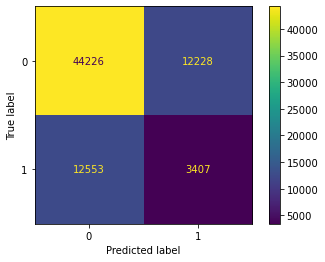

In [6]:
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train_ready, y_train)
plot_confusion_matrix(dummy, X_test_ready, y_test)
dummy.score(X_test_ready, y_test)

Training accuracy of Logistic Regression is: 78.41
Accuracy of Logistic Regression is: 78.24
Recall of Logistic Regression is: 9.91


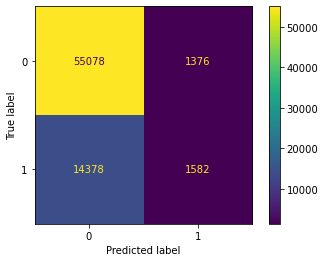

In [7]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42)
lr.fit(X_train_ready,y_train)
train_pred = lr.predict(X_train_ready)
lr_pred = lr.predict(X_test_ready)
train_accuracy = accuracy_score(y_train, train_pred)*100
lr_accuracy= accuracy_score(y_test, lr_pred)*100
lr_recall = recall_score(y_test, lr_pred)*100
print('Training accuracy of Logistic Regression is: {:.2f}'.format(train_accuracy))
print('Accuracy of Logistic Regression is: {:.2f}'.format(lr_accuracy))
print('Recall of Logistic Regression is: {:.2f}'.format(lr_recall))
plot_confusion_matrix(lr, X_test_ready, y_test);

Being able to predict almost 80 percent of the time, should be enough to make you money with this type of investment. However if we're trying to find an edge to get very good value, our model needs to be more sensitive to the defaulted loans. Meaning when our model thinks a loan is safe, we need to be very confident that that's the case. Even if our model tells us that a lot of loans will default when in reality only a few will, if narrow down our investments to the loans the model does not think will default, we get a much better return. So far our model does a very poor job identifying the bad loans. This is largely due to the great imbalance in the classes, which makes it very hard for the model to learn what a defaulted loan would look like.

There are 3 ways I can think of to help with this:
* Alter the weights of each class to put more weight on the minority class. 
* Lower the threshhold for predicting a "1" to make it more sensitive. 
* Oversample the minority class with a over-sampling technique like SMOTE to correct the imbalance.

Note that the better recall score will probably come at the cost of overall accuaracy.

Normally I would use SMOTE to fix this imbalance, but in this case I think it is simpler to lower the threshold of the probability function to be more conservative. Because there are so many loans to choose to invest in, we can let our model be extremely picky with which loans it thinks is safe. This should get us the best returns on our investment. So even though I want to get the highest recall possible, I will optimize the model for accuracy, and then adjust the threshold to get the best returns.

I'll now run a grid search on Logistic regression, KNN and Random forest to see which performs best.

In [8]:
# # instantiate the SMOTE object and fit and sample on the training data.
# smote = SMOTE(random_state=42)
# X_train_sm, y_train_sm = smote.fit_sample(X_train_ready, y_train)
# # check to see the new balance of classes
# print('Balance before SMOTE:')
# print(y_train.value_counts(normalize=True))
# print('')      
# print('Balance after SMOTE:')
# print(y_train_sm.value_counts(normalize=True))

In [9]:
# function for the grid search on logistic regression 
def logreg(X_train, X_test, y_train, y_test, cv=3):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_iter': [75, 100, 150, 200],
    'C': [0.01, 0.1, 1, 10],
    # because I used smote to fix the imbalance I will give it the option of weighting the paid loans more as well
    'class_weight': [{0:2, 1:1}, {0:1, 1:1}, {0:1, 1:3}, {0:1, 1:4}]
    }
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    # print out the best parameters
    params = gs.best_params_
    print(f"Best class_weight: {params['class_weight']}, Best 'C': {params['C']}, Best 'max_iter': {params['max_iter']}")
    # instantiate new logistic regression with these parameters
    lr = LogisticRegression(max_iter=params['max_iter'], C=params['C'],
                            class_weight=params['class_weight'],random_state=42 )
    print('')
    # print the training accuracy
    lr.fit(X_train, y_train)
    train_pred = lr.predict(X_train)
    print('Training accuracy:', round(accuracy_score(y_train, train_pred), 4)*100)
    # Run cross-validation using the new logistic regression and print the accuracy 
    cv_results = cross_val_score(lr, X_train, y_train, cv=cv)
    print("Mean Cross-Validation accuracy:", round(cv_results.mean(),4)*100)
    # print the test accuracy score
    y_pred = lr.predict(X_test)
    print('Testing accuracy:', round(accuracy_score(y_test, y_pred), 4)*100)
    # Plot Confusion Matrix
    plot_confusion_matrix(lr, X_test, y_test)

Best class_weight: {0: 1, 1: 1}, Best 'C': 1, Best 'max_iter': 75

Training accuracy: 78.41
Mean Cross-Validation accuracy: 78.41
Testing accuracy: 78.24

(This cell takes 201 seconds to run)


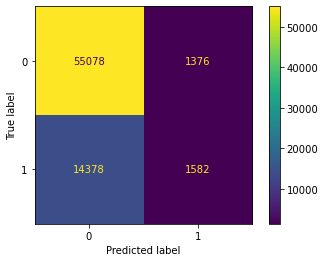

In [10]:
cell_start = time.time()
logreg(X_train_ready, X_test_ready, y_train, y_test)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

In [11]:
len(y_test)

72414

In [12]:
# function for the grid search on KNearest Neighbors 
def knn(X_train, X_test, y_train, y_test, cv=3):
    
    # Set GridSearchCV hyperparameters to compare & select
    param_grid = {
    'n_neighbors': [3,5,9,13],
    'metric': ['minkowski', 'manhattan'],
    'weights': ['uniform', 'distance']
    }
    
    # Instantiate & fit LogReg model for GridSearch
    grid_knn = KNeighborsClassifier()
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_knn, param_grid=param_grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    # print out the best parameters
    params = gs.best_params_
    print(f"Best 'n_neighbors': {params['n_neighbors']}, Best 'metric': {params['metric']},\
          Best 'weights': {params['weights']}")
    print('')
    # instantiate new logistic regression with these parameters
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'],
                            weights=params['weights'])
    # print the training score
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train)
    print('Training accuracy:', round(accuracy_score(y_train, train_pred), 4)*100)
    # Run cross-validation using the new knn and print the accuracy
    cv_results = cross_val_score(knn, X_train, y_train, cv=cv)
    print("Mean Cross-Validation accuracy:", round(cv_results.mean(), 4)*100)
    # print testing accuracy
    y_pred = knn.predict(X_test)
    print('Testing accuracy:', round(accuracy_score(y_test, y_pred), 4)*100)
    # Plot Confusion Matrix
    plot_confusion_matrix(knn, X_test, y_test)

Best 'n_neighbors': 13, Best 'metric': manhattan,          Best 'weights': uniform

Training accuracy: 79.64
Mean Cross-Validation accuracy: 77.36
Testing accuracy: 77.27000000000001

(This cell takes 1086 seconds to run)


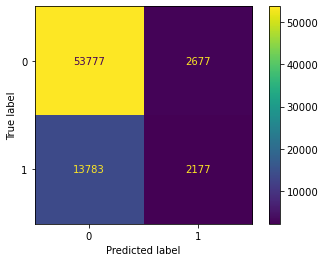

In [14]:
# depending on computer power, this cell can take over a half hour to run.
cell_start = time.time()
knn(X_train_ready, X_test_ready, y_train, y_test)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

In [15]:
# make a function for the grid search on random forest to avoid repetitiveness 
def random_forest(X_train, X_test, y_train, y_test, cv=3):
    
    # Set GridSearchCV hyperparameters to compare & select
    param_grid = {
    'n_estimators': [100, 125, 150],
    'max_depth':  [15, 25],
    'min_samples_split': [2, 5]
     }
    # Instantiate & fit LogReg model for GridSearch
    grid_rf = RandomForestClassifier(random_state=42)
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=param_grid, cv=cv, scoring='accuracy')
    gs.fit(X_train, y_train)
    # print out the best parameters
    params = gs.best_params_
    print(f"Best 'n_estimators': {params['n_estimators']}, Best 'max_depth': {params['max_depth']},\
                       Best 'min_samples_split': {params['min_samples_split']}")
    print('')
    # instantiate new logistic regression with these parameters
    rf = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'], 
                                min_samples_split=params['min_samples_split'], random_state=42 )
    # print the training score
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    print('Training accuracy:', round(accuracy_score(y_train, train_pred), 4)*100)
    # Run cross-validation using the new Random forest
    cv_results = cross_val_score(rf, X_train, y_train, cv=cv)
    print("Mean Cross-Validation accuracy:", round(cv_results.mean(), 4)*100)
    # print testing accuracy
    y_pred = rf.predict(X_test)
    print('Testing accuracy:', round(accuracy_score(y_test, y_pred), 4)*100)
    # Plot Confusion Matrix
    plot_confusion_matrix(rf, X_test, y_test)

Best 'n_estimators': 150, Best 'max_depth': 15,                       Best 'min_samples_split': 5

Training accuracy: 80.86
Mean Cross-Validation accuracy: 78.48
Testing accuracy: 78.35

(This cell takes 1986 seconds to run)


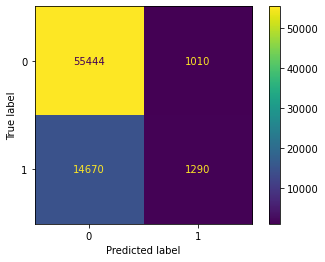

In [16]:
cell_start = time.time()
random_forest(X_train_ready, X_test_ready, y_train, y_test)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

We need to take in to acount that the cross-validation is using data that was oversampled with SMOTE, so the results won't be this good on the test data which still has the imbalance. With that being said, these models should still have good sensitivity on the test data, and in that area KNNis the winner with a 90% sensitivity. With a sensitivity like that, the investor can be confident that very few of the loans the model suggests investing in will default, which means we will almost always be getting the interest from the loan we invest in.

I'll now run the model on the testing data, using the hyperparametrs the grid search chose. I will use the predict_proba method so that I can alter the threshold if I want to be more or less conservative.

In [17]:
# # instantiate model and fit on training data
# final_knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='distance')
# final_knn.fit(X_train_sm, y_train_sm)

# # get the predictions and check the accuracy, recall, and f1 scores
# y_pred = final_knn.predict(X_test_ready)
# knn_accuracy = accuracy_score(y_test, y_pred)
# knn_recall = recall_score(y_test, y_pred)
# knn_f1 = f1_score(y_test, y_pred)

# # print the metrics out
# print('Accuracy:', round(knn_accuracy, 4)*100)
# print('Recall:', round(knn_recall, 4)*100)
# print('F1:', round(knn_f1, 4)*100)

# # plot an ROC curve and a confusion matrix

In [18]:
# # instantiate model and fit on training data
# final_lr = LogisticRegression(max_iter=75, C=0.1, class_weight={0: 1, 1: 1})
# final_lr.fit(X_train_sm, y_train_sm)

# # get the predictions and check the accuracy, recall, and f1 scores
# y_pred = final_lr.predict(X_test_ready)
# lr_accuracy = accuracy_score(y_test, y_pred)
# lr_recall = recall_score(y_test, y_pred)
# lr_f1 = f1_score(y_test, y_pred)

# # print the metrics out
# print('Accuracy:', round(lr_accuracy, 4)*100)
# print('Recall:', round(lr_recall, 4)*100)
# print('F1:', round(lr_f1, 4)*100)

# # plot an ROC curve and a confusion matrix

As we mentioned earlier the real value is going to be on the high interest loans where there is more risk involved. I will seperate the high risk loans from the rest and train the model on those. 

Looking back at our analysis we saw that loans with a grade of "D" or worse had an average interest rate of 18% or more. So if we only included the grade "D" and down we'd have a average interest rate of: 

In [19]:
bad_df = accepted_df[accepted_df.grade.isin(['D', 'E', 'F', 'G'])].copy()
print(bad_df['int_rate'].mean())
bad_df.loan_status.value_counts(normalize=True)

21.032032931174378


0    0.622755
1    0.377245
Name: loan_status, dtype: float64

Instead of an average of:

In [20]:
print(accepted_df.int_rate.mean())
accepted_df.loan_status.value_counts(normalize=True)

13.385680636514664


0    0.782096
1    0.217904
Name: loan_status, dtype: float64

I'll do the same pre-proccessing that I did earlier.

In [21]:
# use the same label encoder and transform the categorical features
bad_df['application_type'] = le.fit_transform(bad_df['application_type'])
bad_df['term'] = le.fit_transform(bad_df['term'])
bad_df['grade'] = le.fit_transform(bad_df['grade'])
bad_df['home_ownership'] = le.fit_transform(bad_df['home_ownership'])
bad_df['emp_length'] = le.fit_transform(bad_df['emp_length'])
bad_df

,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
11,1,15.77,0,28.44,0,10,23000.0,54000.0,0,1,2016-01-01,471xx
18,0,15.77,0,23.29,0,1,11900.0,35000.0,0,3,2016-01-01,114xx
22,1,18.99,1,14.45,0,4,16800.0,115000.0,0,1,2016-01-01,114xx
27,1,15.77,0,8.00,0,1,15000.0,75000.0,0,1,2016-01-01,038xx
30,1,15.77,0,11.33,0,6,19600.0,90000.0,0,3,2016-01-01,721xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482718,1,18.94,0,31.15,0,7,15000.0,68000.0,0,1,2018-12-01,255xx
482731,1,19.92,0,26.89,0,4,16000.0,54000.0,0,3,2018-12-01,275xx
482732,0,19.92,0,16.80,0,1,14000.0,75000.0,0,3,2018-12-01,334xx
482733,0,20.89,0,17.19,0,1,12000.0,52000.0,0,1,2018-12-01,928xx


In [22]:
# split the data into a training set and testing set.
# I won't be using the date or zip_codes for the training.
bad_X = bad_df.drop(['loan_status', 'date', 'zip_code'],axis=1).copy()
bad_y = bad_df['loan_status'].copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(bad_X, bad_y, test_size=0.15, random_state=42)

In [23]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96379 entries, 102944 to 75657
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   term              96379 non-null  int32  
 1   int_rate          96379 non-null  float64
 2   grade             96379 non-null  int32  
 3   dti               96379 non-null  float64
 4   emp_length        96379 non-null  int32  
 5   loan_amnt         96379 non-null  float64
 6   annual_inc        96379 non-null  float64
 7   application_type  96379 non-null  int32  
 8   home_ownership    96379 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 5.5 MB


In [24]:
# seperate the numerical and categorical columns for training and testing data so that I can scale the numerical
# and then concatenate them.
# reset the index for smoothe concatenation
num_train2 = X_train2.select_dtypes(include='float64').reset_index(drop=True)
num_test2 = X_test2.select_dtypes(include='float64').reset_index(drop=True)
cat_train2 = X_train2.select_dtypes(include='int32').reset_index(drop=True)
cat_test2 = X_test2.select_dtypes(include='int32').reset_index(drop=True)

# fit and transform the scaler on training and testing data
sc_num_train2 = sc.fit_transform(num_train2)
sc_num_test2 = sc.transform(num_test2)
# put the scaled data back into a dataframe
sc_train_df2 = pd.DataFrame(sc_num_train2, columns=num_train2.columns)
sc_test_df2 = pd.DataFrame(sc_num_test2, columns=num_test2.columns)

# concatenate back together
X_train_ready2 = pd.concat([sc_train_df2, cat_train2], axis=1)
X_test_ready2 = pd.concat([sc_test_df2, cat_test2], axis=1)

0.6577871682271385

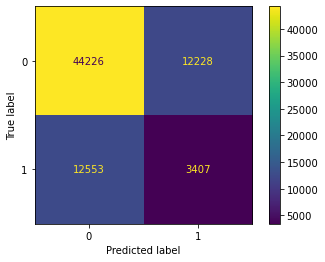

In [25]:
# heres another dummy classifier
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train_ready, y_train)
plot_confusion_matrix(dummy, X_test_ready, y_test)
dummy.score(X_test_ready, y_test)

Best class_weight: {0: 1, 1: 1}, Best 'C': 0.1, Best 'max_iter': 75

Training accuracy: 63.519999999999996
Mean Cross-Validation accuracy: 63.51
Testing accuracy: 63.36000000000001

(This cell takes 31 seconds to run)


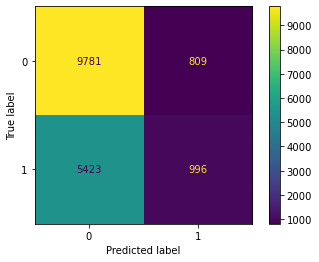

In [26]:
cell_start = time.time()
logreg(X_train_ready2, X_test_ready2, y_train2, y_test2)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

Best 'n_neighbors': 13, Best 'metric': minkowski,          Best 'weights': uniform

Training accuracy: 67.34
Mean Cross-Validation accuracy: 60.540000000000006
Testing accuracy: 60.629999999999995

(This cell takes 150 seconds to run)


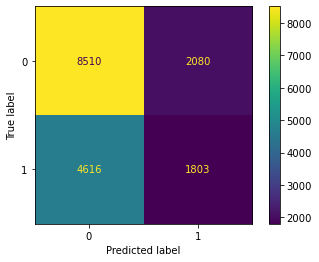

In [27]:
cell_start = time.time()
knn(X_train_ready2, X_test_ready2, y_train2, y_test2)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

Best 'n_estimators': 125, Best 'max_depth': 15,                       Best 'min_samples_split': 2

Training accuracy: 77.28
Mean Cross-Validation accuracy: 63.27
Testing accuracy: 62.96000000000001

(This cell takes 381 seconds to run)


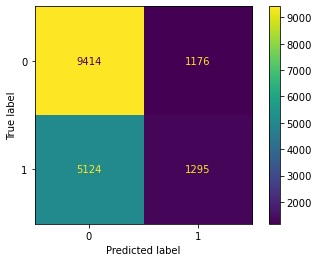

In [28]:
cell_start = time.time()
random_forest(X_train_ready2, X_test_ready2, y_train2, y_test2)
print("")
print(f'(This cell takes {int(time.time() - cell_start)} seconds to run)')

In [29]:
notebook_end = time.time()
print(f'This notebook takes {int(notebook_end - notebook_start)} seconds to run')

This notebook takes 4257 seconds to run
